In [1]:
import matplotlib.pyplot as plt  
import numpy as np
from sklearn import datasets,decomposition,manifold
from andylearn import mnist, KNNneighbor
import scipy
import pylab
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib inline
#%pylab inline

In [27]:
def NPE(data, k, d):
    '''
    data is the original data. m*n(m=samples, n=dimensions)
    '''
    data = np.matrix(data)
   
    N = data.shape[0]
    D = data.shape[1]
    # step 1
    # find the nearest neighbors (k). Here we get the distance from (x-y)^2
    # distance
    data_tmp = np.sum(np.multiply(data, data), axis=1)
    distance=np.mat(data_tmp + data_tmp.T - 2*data*data.T)
    sort_index = np.argsort(distance,axis=1)
    # k nearest neibors
    neibors = sort_index[:,1:k+1]

    # step 2
    # weights
    W = np.zeros((N, N))
    
    # Gram Matrix
    if(k > D):
        add = 0.001
    else:
        add = 0
    for i in range(N):
        neibors_i = neibors[i].A[0]
        G = data[neibors_i[:]] - data[i] 
        G = np.dot(G, G.T)
        G = G + add * np.eye(k)*np.trace(G)
        G_I = G.I
        w_i = np.sum(G_I,axis=1) / np.sum(G_I)
        w_i = w_i.flatten([0])    
        W[i][neibors[i]]=w_i
    
    # Step 3
    # M 
    
    M=np.eye(N) - W
    M=np.dot(M.T, M)
    
    datatmp=data.T
    
    #SVD
    U, s, V = np.linalg.svd(datatmp)
    U = U[:, 0:np.linalg.matrix_rank(datatmp)]
    datatmp = np.dot(U.T, datatmp)
    
    # eig
    eig_values, eig_vectors = scipy.linalg.eig(np.dot(np.dot(datatmp, M), datatmp.T), np.dot(datatmp, datatmp.T))
    eig_index = np.argsort(eig_values)
    mapping = eig_vectors[:,eig_index[0:d]]
    mapping = np.dot(mapping.T, U.T)
    
    return mapping

In [17]:
#orl face loaded
data=scipy.io.loadmat("data/orl_faces/32_32/ORL_32x32.mat")
face = data['fea']/256
label = data['gnd']

NPE done


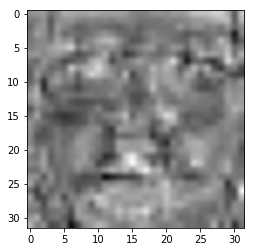

In [18]:
def NPE_faces():
    matfn = 'data/orl_faces/32_32/2Train/3.mat'
    index = scipy.io.loadmat(matfn)
    testIdx = index['testIdx'] -1    ### python 从0 开始
    trainIdx = index['trainIdx'] -1  ### python 从0 开始
    trainface = face[trainIdx]
    
    trainface = np.squeeze(trainface) 
    
    
    mapping = NPE(trainface/255, 20, 8)
    tmp=mapping[1]
    tmp=tmp.reshape(32, 32).astype(float)
    pylab.imshow(tmp.T, cmap='gray', interpolation='hamming')
    pylab.show()
NPE_faces()

In [32]:
def NPE_ORL_acuracy(l, k, d):
    ## 32 * 32 ORL_faces 
    s=0.0
    for i in range(50):
        matfn = 'data/orl_faces/32_32/'+str(l)+'Train/'+str(i+1)+'.mat'
        index = scipy.io.loadmat(matfn)
        testIdx = index['testIdx'] -1  
        trainIdx = index['trainIdx'] -1
        trainface = face[trainIdx]
        trainlabel = np.squeeze(label[trainIdx])
        trainface = np.squeeze(trainface) 
        
        testface = face[testIdx]
        testlabel =  np.squeeze(label[testIdx])
        testface = np.squeeze(testface)  
       
        mapping = NPE(trainface, k, d)
        
        traindata = np.dot(mapping, trainface.T)
        testdata = np.dot(mapping, testface.T)
        
        s += KNNneighbor.accuracy(traindata.T, trainlabel, testdata.T, testlabel, 1)
        
    return s/50

print(NPE_ORL_acuracy(5, 50, 80))

NPE done
NPE done
NPE done
NPE done
NPE done
NPE done
NPE done
NPE done
NPE done
NPE done
NPE done
NPE done
NPE done
NPE done
NPE done
NPE done
NPE done
NPE done
NPE done
NPE done
NPE done
NPE done
NPE done
NPE done
NPE done
NPE done
NPE done
NPE done
NPE done
NPE done
NPE done
NPE done
NPE done
NPE done
NPE done
NPE done
NPE done
NPE done
NPE done
NPE done
NPE done
NPE done
NPE done
NPE done
NPE done
NPE done
NPE done
NPE done
NPE done
NPE done
0.8831


In [20]:
def baseline(l):
    ## 32 * 32 ORL_faces 
    s=0.0
    for i in range(50):
        matfn = 'data/orl_faces/32_32/'+str(l)+'Train/'+str(i+1)+'.mat'
        index = scipy.io.loadmat(matfn)
        testIdx = index['testIdx'] -1
        trainIdx = index['trainIdx'] -1
        trainface = face[trainIdx]
        trainlabel = np.squeeze(label[trainIdx])
        trainface = np.squeeze(trainface) 
        testface = face[testIdx]
        testlabel = np.squeeze(label[testIdx])
        testface = np.squeeze(testface)  
        
        s+=KNNneighbor.accuracy(trainface, trainlabel, testface, testlabel, 1)
    return s/50

baseline(5)

0.88090000000000002

NPE done


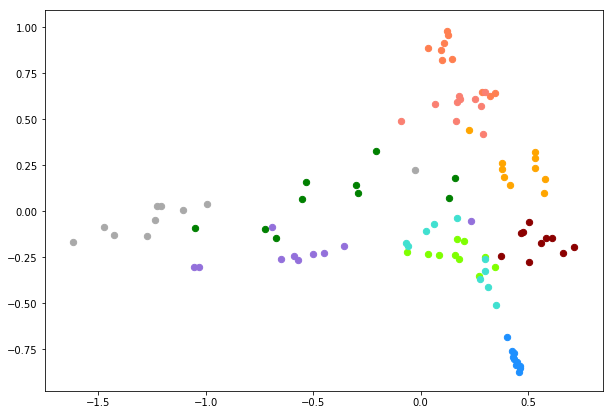

In [24]:
def NPE_ORL_scatters():
    # the first 100 samples
    face100 = np.squeeze(face)[:100]
    label100 = np.squeeze(label)[:100]
    mapping = NPE(face100, 10, 2)
    
    low_data = np.dot(mapping, face100.T).T
 
    fig = plt.figure(figsize=(10,7))
    plotwindow = fig.add_subplot(111)
    a = np.array(low_data)

    # draw the scatters
    color = ['green','dodgerblue','chartreuse','turquoise','orange','coral','salmon','darkgray','darkred','mediumpurple']
    for j in range(len(low_data)):
        plt.scatter(a[j][0], a[j][1],s=40, c=color[label100[j]-1])
    plt.show()
NPE_ORL_scatters();